<a href="https://colab.research.google.com/github/LeVuMinhHuy/-CrNe-Lab1/blob/master/NaiveBayes_spamEmails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Báo cáo Bài tập lớn môn Học máy 
## Hiện thực bộ phân lớp Naive Bayes và ứng dụng vào bài toán phân loại tin nhắn spam


## Cấu hình ban đầu

In [1]:
dataset = "spam.csv"

## Import các thư viện cơ bản để xử lý tính toán và phân tích

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Tải tập dataset 

In [5]:
import pandas as pd

data = pd.read_csv(dataset, encoding='latin-1')
data.head(n=10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [7]:
data.iloc[2]

v1                                                         spam
v2            Free entry in 2 a wkly comp to win FA Cup fina...
Unnamed: 2                                                  NaN
Unnamed: 3                                                  NaN
Unnamed: 4                                                  NaN
Name: 2, dtype: object

Có hai loại nhãn là:

* `ham`: Là những tin nhắn mong muốn, không phải spam. (https://vi.wiktionary.org/wiki/ham_e-mail)
* `spam`: Là những tin nhắn rác

## Phân tích sự phân phối của các tin nhắn spam và non-spam

In [8]:
count_Class=pd.value_counts(data["v1"], sort= True)

In [9]:
count_Class

ham     4825
spam     747
Name: v1, dtype: int64

In [10]:
type(count_Class)

pandas.core.series.Series

ham     4825
spam     747
Name: v1, dtype: int64


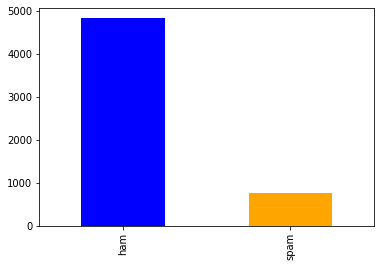

In [11]:
count_Class=pd.value_counts(data["v1"], sort= True)
print(count_Class)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
# plt.title('Bar chart')
plt.show()

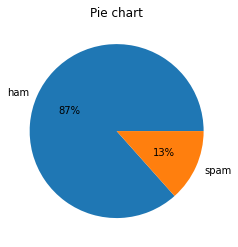

In [12]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Phân tích dữ liệu

Chúng em muốn kiểm tra tần suất xuất hiện của các từ trong những tin nhắn spam cũng như non-spam. Để xem những từ nào sẽ được xuất hiện nhiều nhất trong mỗi loại, từ đó xem được điểm khác biệt giữa những tin nhắn spam và non-spam

### Tách từ

Đầu tiên chúng em sẽ tách từng từ trong mỗi câu ra để đếm. Ví dụ cách tách các tin nhắn ham:

In [17]:
# list all ham messages
ham_messages=data[data['v1']=='ham']["v2"]
ham_messages.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: v2, dtype: object

In [18]:
# Join all ham messages for counting
ham_words = " ".join(ham_messages).split()
ham_words[:10]

['Go',
 'until',
 'jurong',
 'point,',
 'crazy..',
 'Available',
 'only',
 'in',
 'bugis',
 'n']

In [19]:
#Number of vocabularies in ham_words
len(ham_words)

68518

### Phân tích tỉ lệ xuất hiện các từ trong các tin nhắn Ham/Spam

### Lấy 20 từ xuất hiện nhiều nhất trong các tin nhắn ham

In [20]:
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
df1

,words in non-spam,count
0,to,1530
1,you,1458
2,I,1436
3,the,1019
4,a,969
5,and,738
6,i,736
7,in,734
8,u,645
9,is,638


### Lấy 20 từ xuất hiện nhiều nhất trong các tin nhắn spam

In [21]:
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
df2

,words in spam,count_
0,to,604
1,a,358
2,your,187
3,call,185
4,or,185
5,the,178
6,2,169
7,for,169
8,you,164
9,is,143


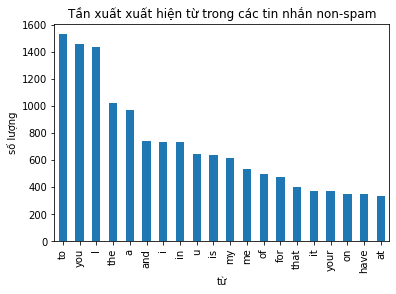

In [23]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('Tần xuất xuất hiện từ trong các tin nhắn non-spam')
plt.xlabel('từ')
plt.ylabel('số lượng')
plt.show()

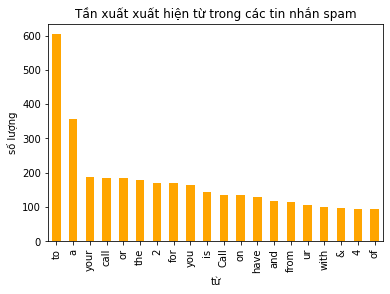

In [24]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('Tần xuất xuất hiện từ trong các tin nhắn spam')
plt.xlabel('từ')
plt.ylabel('số lượng')
plt.show()

Có thể thấy phần lớn những từ thường xuyên xuất hiện trong cả 2 tập tin nhắn là những "stop words", ví dụ như 'to', 'a', 'or', .... <p>

Những stop words này là những stop words phổ biến. Trong một số trường hợp, sẽ có những stop words đặc biệt phản ánh đúng ý nghĩa của tập dữ liệu đó (ví dụ phân loại truyện cổ tích và paper nghiên cứu khoa học thì những stop words là đại từ nhân xưng sẽ phản ánh tốt hơn về tập truyện cổ tích) 

Trong bài toán này, chúng em thấy không có trường hợp nào quá đặc biệt để giữ lại.

Vì vậy, chúng em sẽ tiếp tục loại bỏ đi những stop words này trước khi train để chính xác hơn

## Tiền xử lý dữ liệu

### Chúng em sẽ sử dụng các kỹ thuật tokenizing, chuyển đổi sang bộ véc tơ và loại bỏ các stop words

In [29]:
data["v2"].head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [30]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

In [31]:
X.shape

(5572, 8404)

Ta được kết quả X là một véc tơ có số chiều là 5572 × 8404. Tương đương với 5572 số văn
bản (tổng số tin nhắn), và nhóm đã chuẩn hóa về 8404 chiều tương đương với độ dài của
mỗi văn bản. Với mỗi chiều này sẽ được gán giá trị bằng 1 nếu từ tương ứng với chiều đó
xuất hiện trong văn bản, và 0 nếu không xuất hiện.

In [32]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
#xem một số kí tự
X.toarray()[X.toarray()[:,0] !=0]

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

Vậy ta đã có được một bộ vector (5572, 8404) để chuẩn bị cho việc đưa vào bộ học máy
Naive Bayes

## Phân tích kỳ vọng

Trước khi đi sâu vào training và đánh giá, nhóm cần xác định kỳ vọng của bài toán này là gì. Cần training những gì và đánh giá cái gì.

Nên tập trung vào hệ số recall hay precision. Hãy làm rõ như sau:

Xét 2 trường hợp:

1. Khi mở trình quản lý tin nhắn bất kỳ lên, sau khi
đọc những tin nhắn mới, ta thấy có một vài tin nhắn là spam. Và đơn giản chúng ta sẽ chuyển nó vào hộp thoại những tin nhắn spam.
2. khi mở trình quản lý tin nhắn bất kỳ lên, ta sẽ không thấy một vài tin nhắn quan trọng hoàn toàn không phải spam nhưng lại biến mất ở hộp tin Inbox, vì nó đã bị phân lớp sai vào hộp thoại spam. Chuyện này khá nguy hiểm vì ta thường ít vào hộp thoại spam để kiểm tra và khả năng cao là ta sẽ mất tin nhắn quan trọng đó

Và nhóm sẽ mong muốn kết quả sau khi train sẽ giúp bộ phân loại cho ra trường hợp 1 thay vì trường hợp 2. Hay nói cách khác

Phải giảm thiểu tối đa FP (False Positive), hay tương đương với việc tối đa hóa Precision, nếu Precision bằng 1 có nghĩa là không có bất kỳ tin nhắn nào bị bỏ sót ở hộp thoại spam. Và việc Recall có hơi thấp là chuyện chấp nhận được, và điểm rất hay ở bài toán phân loại tin nhắn spam này với Naive Bayes là recall sẽ luôn được cải thiện, và cải thiện rất nhanh bằng cách ta chuyển những tin nhắn spam vào
hộp thoại spam sau khi đọc được (vì việc cập nhật trọng số rất nhanh với Naive Bayes).

## Phân tập training và testing

In [34]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [35]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})

In [36]:
data["v1"].head()

0    0
1    0
2    1
3    0
4    0
Name: v1, dtype: int64

In [40]:
#split training/test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)

X_train = X_train.toarray()
X_test = X_test.toarray()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


## Hiện thực thuật toán Naive Bayes

### Chọn hàm phân phối

Nhóm chúng tôi chọn phân phối Đa thức (Multinomial distribution) cho bài toán phân loại thư rác này.

Khác với các phân phối thường gặp của bộ phân lớp Naive Bayes như Gaussian hay Bernoulli. Nhóm chọn phân phối Đa thức (Multinomial) vì phân phối này thích hợp với những thuộc tính rời rạc (discrete features), cụ thể là số đếm các từ trong một văn bản cho bài toán của nhóm.

Và sẽ có một hệ số làm mềm Laplace $\alpha$ chạy trong
khoảng từ 1/100000 đến 20 với step là 0.11 . Sau đó chọn lọc lại $\alpha$ tốt nhất.

In [41]:
import numpy as np
np.set_printoptions(precision=6)

class MultinomialNB(object):
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_
                for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

def accuracy_score(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1
    return correct / float(len(actual)) * 100.0

In [42]:
# Chọn alpha
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

Kết quả đánh giá sau khi 10 α đầu tiên được áp dụng

In [43]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,99.866059,97.444263,0.920635,0.895753
1,0.11001,99.785695,97.607395,0.936508,0.893939
2,0.22001,99.785695,97.716150,0.936508,0.900763
3,0.33001,99.758907,97.716150,0.936508,0.900763
4,0.44001,99.705331,97.716150,0.936508,0.900763
5,0.55001,99.624967,97.661773,0.936508,0.897338
6,0.66001,99.651755,97.607395,0.932540,0.896947
7,0.77001,99.651755,97.607395,0.924603,0.903101
8,0.88001,99.624967,97.607395,0.924603,0.903101
9,0.99001,99.598178,97.607395,0.920635,0.906250


Có thể thấy kết quả đang
khá tốt. Nhưng với việc mong muốn cực đại hóa Precision như đã trình bày, và precision
vẫn đang tăng (mặc dù recall có thể giảm), nhóm sẽ tiếp tục tăng hệ số $\alpha$ lên.

Đây là kết quả tốt nhất

In [44]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy    97.964104
Test Accuracy     96.954867
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [46]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,97.964104,96.954867,0.777778,1.0
144,15.84001,97.964104,96.954867,0.777778,1.0
145,15.95001,97.964104,96.954867,0.777778,1.0
146,16.06001,97.937316,96.954867,0.777778,1.0
147,16.17001,97.937316,96.954867,0.777778,1.0


Có thể thấy Precision hiện tại đã đạt mức mong muốn là 1.0 mặc dù recall chỉ ở mức
0.77. Bên cạnh đó, có thể có nhiều $\alpha$ cho Precision đạt đến ngưỡng bằng 1.0, chúng ta
cần lấy $\alpha$ vừa làm precision tối đa và test accurate cao nhất.

In [47]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy    97.964104
Test Accuracy     96.954867
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

#### Confusion matrix 

In [49]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196


## Kết  luận

1. Trong 1839 tin nhắn của tập test, không có bất kỳ tin nhắn bình thường nào bị
phân loại nhầm sang hộp thoại spam. Việc này đảm bảo được tất cả những tin nhắn
không phải spam được gửi đến, chúng ta đều đọc được<p>
2. Có 56 tin nhắn trên tổng số 1839 tin nhắn của tập test bị phân lớp sai sang hộp
thoại inbox khi chúng chính là những tin nhắn spam. Việc này chúng ta có thể dễ
dàng di chuyển chúng vào hộp thoại spam, đồng thời cập nhật lại hệ số cho thuật
toán, giúp việc phân loại đúng hơn về sau này.